# MODELING CLASSIFICATION PROBABILITY OF DEFAULT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

%config IPCompleter.greedy=True
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")

## UPLOAD DATA

In [2]:
path ='../../'

In [3]:
name = 'df_tablon_pd.pickle'

In [4]:
df = pd.read_pickle(path + '/02_Data/03_Work/' + name)

In [5]:
x = df.drop(columns='target_pd')
y = df.target_pd

## MODELLING

### Validacion Dataset

In [6]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### pipe and the dictionary of algorithms, parameters and values ​​to test

In [7]:
pipe = Pipeline([('algorithm',LogisticRegression())])

grid = [{'algorithm': [LogisticRegression(solver = 'saga', n_jobs=-1)],
         'algorithm__penalty': ['elasticnet', 'l1', 'l2'],
         'algorithm__C': [0,0.25,0.5,0.75,1]}
       ]

### Optimize hyper parameters

####  grid search

In [8]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 5, 
                           scoring = 'roc_auc',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [9]:
sal = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(5)
sal

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_algorithm__C,param_algorithm__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.46,1.96,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",1,l1,"{'algorithm': LogisticRegression(C=1, n_jobs=-...",0.70,0.69,0.70,0.70,0.70,0.70,0.01,1
1,14.15,2.03,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",1,l2,"{'algorithm': LogisticRegression(C=1, n_jobs=-...",0.70,0.69,0.70,0.70,0.70,0.70,0.01,2
2,16.79,1.45,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.75,l1,"{'algorithm': LogisticRegression(C=1, n_jobs=-...",0.70,0.69,0.70,0.70,0.70,0.70,0.01,3
3,14.57,1.04,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.75,l2,"{'algorithm': LogisticRegression(C=1, n_jobs=-...",0.70,0.69,0.70,0.70,0.70,0.70,0.01,4
4,17.78,0.46,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.50,l1,"{'algorithm': LogisticRegression(C=1, n_jobs=-...",0.70,0.69,0.70,0.70,0.70,0.70,0.01,5


Train with the best model.

In [10]:
rl = LogisticRegression(solver = 'saga', n_jobs=-1, C = 1, penalty = 'l1')

rl.fit(train_x,train_y)

LogisticRegression(C=1, n_jobs=-1, penalty='l1', solver='saga')

review the coefficients to see those that are zero and the most important variables.

In [11]:
coef = pd.DataFrame(data = rl.coef_, columns = rl.feature_names_in_).stack().droplevel(level = 0).sort_values()
coef

tipo_interes_mms                       -2.51
principal_mms                          -1.55
ingresos_mms                           -1.12
ingresos_verificados_Not Verified      -0.34
num_cuotas_ 36 months                  -0.30
finalidad_vacation                     -0.25
vivienda_MORTGAGE                      -0.20
finalidad_car                          -0.15
finalidad_other                        -0.13
vivienda_OWN                           -0.08
ingresos_verificados_Source Verified   -0.07
finalidad_credit_card                  -0.07
finalidad_medical                      -0.06
finalidad_house                        -0.04
antigüedad_empleo_oe_mms               -0.00
rating_oe_mms                          -0.00
finalidad_home_improvement              0.00
dti_mms                                 0.00
num_cuotas_ 60 months                   0.00
antigüedad_empleo_oe                    0.01
finalidad_debt_consolidation            0.02
vivienda_RENT                           0.04
ingresos_v

IMPORTANT

We see strange things like the sign of the principal and the interest rate are negative.

In other words, according to the model, the less amount you request, the greater the risk of default.

Or the lower the interest rate applied, the greater the risk of default.

In a real situation it could happen, but at least a convincing explanation would be needed.

We will take it for granted here and continue.

## EVALUATION

### Predect in validation

In [13]:
pred = rl.predict_proba(val_x)[:, 1]

In [14]:
roc_auc_score(val_y, pred)

0.6994594938959355

## MODEL REPORTING

### Gain Chart

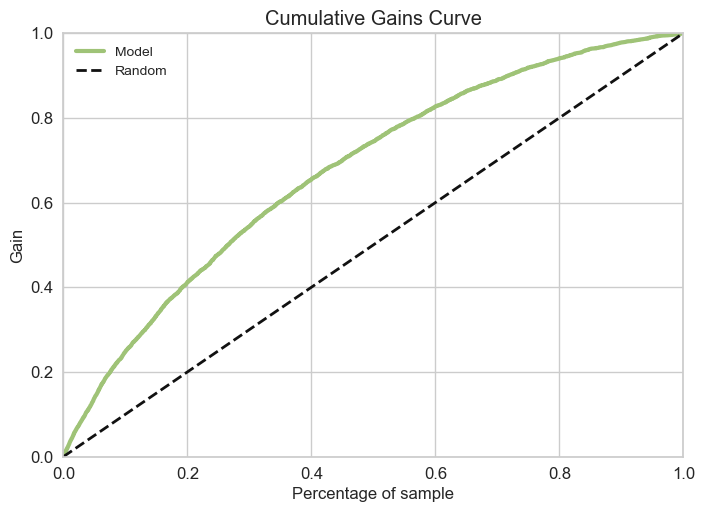

In [19]:
fig, ax = plt.subplots()

skplt.metrics.plot_cumulative_gain(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
plt.legend(labels = ['Model','Random']);

### Lift Chart

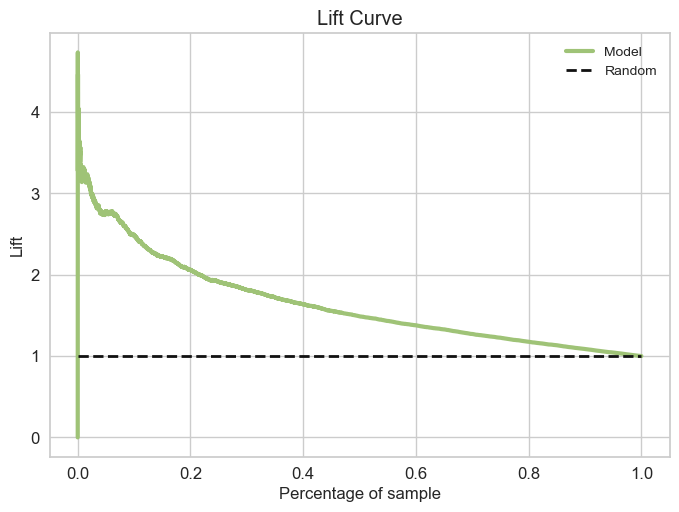

In [18]:
fig, ax = plt.subplots()

skplt.metrics.plot_lift_curve(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
plt.legend(labels = ['Model','Random']);

### ROC Chart

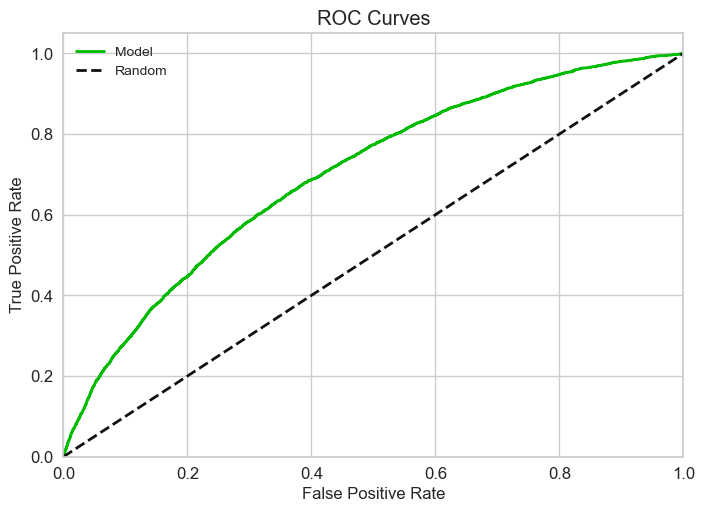

In [20]:
fig, ax = plt.subplots()

skplt.metrics.plot_roc(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
del ax.lines[1] 
del ax.lines[1]
plt.legend(labels = ['Model','Random']);